# Training
> training loop

In [ ]:
#| default_exp training

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2
from nbdev.showdoc import *

In [ ]:
#| export
from slg_generative.models.vae import AutoEncoder
from slg_generative.data.datasets import FashionMnistDataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

/Users/syl20/mambaforge/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
#| export

class Trainer:
    "Trainer for VAE models"

    def __init__(self,
        model:AutoEncoder, # Model
        train_dataloader:torch.utils.data.DataLoader, # Train Dataloader
        validation_dataloader:torch.utils.data.DataLoader, # Validation Dataloader
        loss_func:torch.nn.modules.loss._Loss, # Loss function
        optimizer:torch.optim.Optimizer, # Optimizer
        n_epochs:int, # Number of training epochs
        device:str # Device
    ):
        self.model = model
        self.train_dataloader = train_dataloader
        self.validation_dataloader = validation_dataloader
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
        self.timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.writer = SummaryWriter(f"runs/{self.timestamp}")

    def fit(self):
        # training loop
        running_loss = 0.
        last_loss = 0.
        n_batch_report = 100
        best_vloss = 1_000_000.

        for epoch in tqdm(range(self.n_epochs)):
            self.model.train(True)
            for batch_idx, (x, y) in enumerate(self.train_dataloader):
                x = x.to(self.device)
                self.optimizer.zero_grad()
                x_hat = self.model(x)
                loss = self.loss_func(x_hat, x)
                loss.backward()
                self.optimizer.step()
                
                if batch_idx % n_batch_report == (n_batch_report - 1):
                    print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\r'.format(
                        epoch+1,
                        self.n_epochs,
                        batch_idx * len(x), 
                        len(self.train_dataloader.dataset),
                        n_batch_report * batch_idx / len(self.train_dataloader), 
                        loss.item()), 
                        end='')
                    sample_idx = epoch * len(self.train_dataloader) + batch_idx + 1
                    self.writer.add_scalar('Loss/train', loss.item(), sample_idx)
                    running_loss = 0

            self.model.train(False)
            running_vloss = 0.0
            for i, (x, y) in enumerate(self.validation_dataloader):
                x = x.to(self.device)
                x_hat = self.model(x)
                v_loss = self.loss_func(x_hat, x)
                running_vloss += v_loss.item()
            avg_vloss = running_vloss / (i + 1)
            print('\r Validion Loss: {}\r'.format(avg_vloss))
            self.writer.add_scalar('Loss/validation', avg_vloss, epoch + 1)
            self.writer.flush()

            if avg_vloss < best_vloss:
                best_vloss = avg_vloss
                model_path = f"runs/{self.timestamp}/model_{epoch+1}.pt"
                torch.save(self.model.state_dict(), model_path)

        return self.model


In [ ]:
# device
device = 'mps' if torch.backends.mps.is_available() else 'cpu' # or 'cuda' for nvidia gpus

# data
train_ds = FashionMnistDataset(csv_file="~/Data/fashion-mnist/fashion-mnist_train.csv")
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_ds = FashionMnistDataset(csv_file="~/Data/fashion-mnist/fashion-mnist_test.csv")
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=128, shuffle=True)
# model
autoencoder = AutoEncoder().to(device)
# training params
n_epochs = 5
# optim
opt = Adam(autoencoder.parameters(), lr=1e-3)
# # mean square error loss 
loss_func = nn.MSELoss()

In [ ]:
trainer = Trainer(autoencoder, train_dl, test_dl, loss_func, opt, n_epochs, device)
trainer.fit()

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:02<00:52,  2.75s/it]

 Validion Loss: 0.6283872451963304


 10%|█         | 2/20 [00:05<00:49,  2.77s/it]

 Validion Loss: 0.6230814268317404


 15%|█▌        | 3/20 [00:08<00:47,  2.77s/it]

 Validion Loss: 0.621926503845408


 20%|██        | 4/20 [00:11<00:49,  3.07s/it]

 Validion Loss: 0.6203305706193175


 25%|██▌       | 5/20 [00:15<00:48,  3.25s/it]

 Validion Loss: 0.6193617265435714


 30%|███       | 6/20 [00:18<00:44,  3.18s/it]

 Validion Loss: 0.6182164255576797


 35%|███▌      | 7/20 [00:21<00:40,  3.13s/it]

 Validion Loss: 0.6183422615256491


 40%|████      | 8/20 [00:24<00:37,  3.10s/it]

 Validion Loss: 0.6176317915131774


 45%|████▌     | 9/20 [00:27<00:34,  3.18s/it]

 Validion Loss: 0.6173656914807573


 50%|█████     | 10/20 [00:30<00:31,  3.15s/it]

 Validion Loss: 0.6174960664555996


 55%|█████▌    | 11/20 [00:34<00:28,  3.15s/it]

 Validion Loss: 0.6168823046020314


 60%|██████    | 12/20 [00:37<00:25,  3.16s/it]

 Validion Loss: 0.6161797476720207


 65%|██████▌   | 13/20 [00:40<00:22,  3.18s/it]

 Validion Loss: 0.6147392731678637


 70%|███████   | 14/20 [00:43<00:19,  3.17s/it]

 Validion Loss: 0.6154736770859247


 75%|███████▌  | 15/20 [00:46<00:16,  3.22s/it]

 Validion Loss: 0.6160034620309178


 80%|████████  | 16/20 [00:50<00:12,  3.19s/it]

 Validion Loss: 0.6154555444475971


 85%|████████▌ | 17/20 [00:53<00:09,  3.16s/it]

 Validion Loss: 0.6151369795014586


 90%|█████████ | 18/20 [00:56<00:06,  3.14s/it]

 Validion Loss: 0.6152783307848098


 95%|█████████▌| 19/20 [00:59<00:03,  3.16s/it]

 Validion Loss: 0.6153503105610232


100%|██████████| 20/20 [01:02<00:00,  3.13s/it]

 Validion Loss: 0.6152682040311113


In [ ]:
PATH = "runs/20221202_000258/model_19"
device = torch.device('cpu')
model = AutoEncoder()
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>

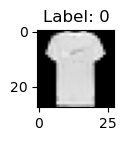

torch.Size([784]) torch.FloatTensor


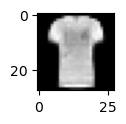

In [ ]:
from slg_generative.data.datasets import FashionMnistDataset
from matplotlib import pyplot as plt
ds = FashionMnistDataset("~/Data/fashion-mnist/fashion-mnist_train.csv")
idx = 10
x, y = ds[idx]
ds.show(idx)
model.eval()
x_hat = model(x)
print(x_hat.shape, x_hat.type())
plt.figure(figsize = (1, 1))
plt.imshow(x_hat.detach().numpy().reshape(28,28),cmap='gray')
plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()